<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 31: Modelling on the Full data For the Cell Type Multiclass Classification</h2>
<hr style="color:green" />

<p>
After Reviewing files 22 - 28 we have experimented with improving the performance of the CNN with more complexity in the Convolutions and the Classifier layers. Taking into account performance increases but also processing time and complexity, the following model will be used here:
</p>
<ul>
<li>CNN, updated architecture without greyscale (from file 28)</li>
</ul>
<p>
Now, in an attempt to improve the performance of both the Binary and the Multiclass models, this process will make use of the full data, ie. both the Main Labels file and the Extras Label file. Because handling these two will be different, processing will be split into separate notebooks.
</p>

<ul>
<li>Binary IsCancerous: All data is labeled, so just add the new data to the dataset</li>
<li>Multiclass Cell Type (here): The data in the Extras file are unlabeled, so therefore, we will need to apply a Semi Supervised Learning approach</li>
</ul>
<p>
In this file, also load the Extra Label data as well as the main data. Then we will perform a Semi Supervised learning process. The basic premise of Semi Supervised learning will be  as follows
</p>

<ol>
<li>Train a baseline model using the labelled Main Data</li>
<li>Predict using this model on the unlabelled Extra Data, taking care to also retain the Softmax score for each value, which is a probability of being that label</li>
<li>Review these predictions, find any that have a high confidence (generally 80% probability is used)</li>
<li>Take this data, and apply that predicted label, called a "pseudo-label". Incorporate this pseudo-labeled data into the training data (also remove them from the extra data)</li>
<li>Train an updated model using the updated training data</li>
<li>Iterate the process from Step 2, until no high confidence data is generated, or capped at a number of rounds</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Configure this script as to whether it runs on Google Colab, or locally

In [2]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = True

In [3]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [4]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [5]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")
dfImagesExtra = pd.read_csv(baseDirectory + "images_extra.csv")

In [6]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


In the Semi Supervised Learning, there is no point in Splitting the Extra data into the flagged Train/Validation/Test Split, as it's unlabelled by Cell Type. Therefore, all extra data will be used as part of the SS Training process

Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [7]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [8]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


# Semi Supervised Learning

Initially, only create data loaders for the validation data and the test data, as these sets will not change. 

In [9]:
celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Define the classe for the CNN. At the moment, we are using the the standard CNN structure with Early stopping (File 22)

In [10]:
# Create a class for the Neural Network
class PT_CNN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self, dropout_prob):
        super(PT_CNN_CellType, self).__init__()
        self.dropProb = dropout_prob

        # 2 Dropout operations on the first two layers, don't do any dropouts on the output layer
        self.classifier = nn.Sequential(
            # Convolution Layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   

            nn.Flatten(),

            # Classifier Layers
            nn.Dropout(p=self.dropProb),
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(inplace=True),   
            
            nn.Dropout(p=self.dropProb),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),    

            nn.Linear(512, 4),           
            nn.Softmax(dim=1)
        )

    # Create the forward function, which is used in training
    def forward(self, x):
        # Run the Sequential Classifier Layer
        return self.classifier(x)           



Create a function to Predict using a particular mode and return results

In [11]:
def predictCellTypeOnDataSetAccuracy(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_celltype = []
    y_pred_celltype = []
    y_pred_celltype_scores = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_celltype.append(labels[j].item())
            y_pred_celltype.append(predicted[j].item())
            y_pred_celltype_scores.append(outputs.data[j].tolist())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(y_celltype, y_pred_celltype)
    f1Score = f1_score(y_celltype, y_pred_celltype, average="micro")

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_celltype, y_pred_celltype))
        print("\n- Accuracy Score: " + str(accuracy))
        print("- Precision Score: " + str(precision_score(y_celltype, y_pred_celltype, average="micro")))
        print("- Recall Score: " + str(recall_score(y_celltype, y_pred_celltype, average="micro")))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))

    return accuracy, y_celltype, y_pred_celltype, y_pred_celltype_scores

Set some standard learning variables that will be used across all iterations

In [12]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 40
patience = 2
disableEarlyStopping = False

if useFullData == False:
    maxEpochs = 5
    patience = 1

Create a Function, that given a PyTorch dataload with a set of data to train in, train a CNN model

In [13]:
def train_celltype_model(iteration, celltype_train_dataloader):
    # Define CNN with the loss and the optimizer
    net = PT_CNN_CellType(0.3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    bestErrorDiff = 99999
    concurrentNonImproves = 0
    currentEpoch = 0

    bestValAcc = -1
    lstEpochs = []
    lstTrainAccs = []
    lstValAccs = []
    for epoch in range(maxEpochs):
        print("Starting Epoch " + str(epoch) + "...")
        currentEpoch = epoch

        # Set the Neural Network into training mode
        net.train()

        # Train through this epoch
        for i, data in enumerate(celltype_train_dataloader, 0):
            # Get the inputs
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform Forward and Backward propagation then optimize the weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
        net.eval()        
        trainingAccuracy, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
            net, "Training", celltype_train_dataloader, True, False)
        validationAccuracy, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
            net, "Validation", celltype_val_dataloader, True, False)

        errorDiff = trainingAccuracy - validationAccuracy
        print("- Accuracy Difference: " + str(errorDiff))

        lstEpochs.append(epoch)
        lstTrainAccs.append(trainingAccuracy)
        lstValAccs.append(validationAccuracy)

        if epoch > 0 and (validationAccuracy - bestValAcc > 0.01):        
            # There is at least percentage point improvement in the validation F1, count this as a 
            # good iteration, regardless of the error difference
            print("- IsGoodStep")
            concurrentNonImproves = 0
            if errorDiff > 0 and errorDiff < bestErrorDiff:  
                bestErrorDiff = errorDiff        
        elif errorDiff < bestErrorDiff:        
            # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
            print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
            concurrentNonImproves = 0
            if errorDiff > 0:
                bestErrorDiff = errorDiff
        else:
            # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
            print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
            concurrentNonImproves += 1
            if disableEarlyStopping == False:
                if concurrentNonImproves >= patience:
                    print("Early Stopping occurred at Epoch " + str(epoch))
                    break

        # update the val F1 score from the previous epoch if it's the best
        if validationAccuracy > bestValAcc:
            bestValAcc = validationAccuracy

    # Create a dataframe that can be used to plot the Training/Validation Loss plot, if we want to use it later
    dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })

    # Once this is done, return the new CNN model and the loss dataframe
    return net, dfLoss


Now, load the initial training data into the celltype_training_data then configure it as a PyTorch Dataloader. This will be for our baseline model

Also, initialize a dataloader for the extra data

In [14]:
celltype_training_data = None

# Create copies of the Train and Extra images dataset, these will be continually updated through SS
dfImagesTrainSS = dfImagesTrain
dfExtraSS = dfImagesExtra

# Create a an initial dataloader for both train and extra images
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize)
    celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainSS = dfImagesTrainSS.iloc[range(500), :].reset_index()
    dfExtraSS = dfExtraSS.iloc[range(500), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize, target_transform=None)
    celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize, target_transform=None)

    
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_extra_dataloader = DataLoader(celltype_extra_data, batch_size=32, shuffle=True, num_workers=2)

### Semi-supervised Loop

Here we will implement the Semi-supervised Learning Loop. This is the high level process:

<ol>
<li>Train a baseline model using the labelled Main Data</li>
<li>Predict using this model on the unlabelled Extra Data, taking care to also retain the Softmax score for each value, which is a probability of being that label</li>
<li>Review these predictions, find any that have a high confidence (generally 80% probability is used)</li>
<li>Take this data, and apply that predicted label, called a "pseudo-label". Incorporate this pseudo-labeled data into the training data (also remove them from the extra data)</li>
<li>Train an updated model using the updated training data</li>
<li>Iterate the process from Step 2, until no high confidence data is generated, or capped at a number of rounds</li>
</ol>

In [15]:
maxIterations = 5
currentIteration = 0
highConfThreshold = 0.97
noMorePseudos = False
extraDataStop = False

In [16]:
previousNet = None
previousValAccuracy = -1

while (currentIteration < maxIterations) and noMorePseudos == False:    
    # Using the current training dataloader, train a model
    print("\nSemi-Supervised Iteration " + str(currentIteration))
    net, dfLoss = train_celltype_model(currentIteration, celltype_train_dataloader)

    # If the extra data was emptied in the previous iteration, we still want to train the model with all the extra data added.
    # But stop here, no need to predict on the (empty) extra data and keep going
    if extraDataStop:        
        print("   Stop SS Cycle - No or Insignficant remaining Extra Data.")
        noMorePseudos = True    
        break

    # Predict using the model on all the extra data. Ensure to get the predicted labels and the softmax probability score
    extraAcc, y_extra_celltype, y_extra_pred_celltype, y_extra_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Extra", celltype_extra_dataloader, True, False)

    # From the list of scores (1 for each class per prediction), get the score for the predicted class
    pred_scores = []
    for i in range(len(y_extra_pred_celltype_scores)):
        # The predicted label will give the index of the related score
        ind = y_extra_pred_celltype[i]
        pred_scores.append(y_extra_pred_celltype_scores[i][ind])

    # Append the predictions and scores to the extra data
    dfExtraPred = dfExtraSS
    dfExtraPred["PredCellType"] = y_extra_pred_celltype    
    dfExtraPred["PredScore"] = pred_scores

    # Get all the predictions that exceed the high confidence threshold. If there are none, set noMorePseudos = True then break the loop
    dfHighConf = dfExtraPred[dfExtraPred["PredScore"] >= highConfThreshold]
    print("   Number of High Conf Predictions: " + str(dfHighConf.shape[0]))
    if dfHighConf.shape[0] == 0:        
        print("   Stop SS Cycle - No High Confidence Predictions.")
        noMorePseudos = True
        break    
    elif dfHighConf.shape[0] <= 20:        
        print("   Stop SS Cycle - Insignificant number of High Conf Predictions (" + str(dfHighConf.shape[0]) + ").")
        noMorePseudos = True
        break    
    else:
        # For the high Confidence records, treat the Predicted score as the pseudolabel, overwriting the cell type (which is -1)
        dfHighConf.loc[:, "cellType"] = dfHighConf.loc[:, "PredCellType"]

        # Add the high conf records to the training data
        dfHighConf = dfHighConf.drop(["PredCellType", "PredScore"], axis=1)
        dfImagesTrainSS = pd.concat([dfImagesTrainSS, dfHighConf], axis=0).reset_index(drop=True)

        # Filter out the high conf records from the extra dataset
        dfExtraSS = dfExtraPred[dfExtraPred["PredScore"] < highConfThreshold].reset_index(drop=True)
        dfExtraSS = dfExtraSS.drop(["PredCellType", "PredScore"], axis=1)

        print("   Updated Train Images Shape: " + str(dfImagesTrainSS.shape))
        print("   Updated Extra Images Shape: " + str(dfExtraSS.shape))
        
        # Update the Data loaders with the updated training and extra sets      
        celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize)
        celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)   


        if dfExtraSS.shape[0] > 20:
            # There is still more data in the extra data, setup the data loader
            celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize) 
            celltype_extra_dataloader = DataLoader(celltype_extra_data, batch_size=32, shuffle=True, num_workers=2)    
        else:       
            extraDataEmpty = True        

        currentIteration += 1

    # Predict on the Validation Set to get an Accuracy
    valAcc, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Validation", celltype_val_dataloader, True, False)        

    if valAcc < previousValAccuracy:
        # This iteration has not improved in accuracy. Discard it, use the last model and end the iterations
        print("   Stop SS Cycle - Validation Accuracy has not improved.")
        print("      Previous Validation Accuracy: " + str(previousValAccuracy))        
        net = previousNet
        noMorePseudos = True
    else:
        # Save the net and accuracy as the previous before the next iteration starts
        previousValAccuracy = valAcc
        previousNet = net

    


Semi-Supervised Iteration 0
Starting Epoch 0...
- Training F1: 0.6533112160265407
- Validation F1: 0.7458777885548011
- Accuracy Difference: -0.0925665725282604
- IsBetter: -0.0925665725282604 : 99999
Starting Epoch 1...
- Training F1: 0.7061375526349368
- Validation F1: 0.7798254122211445
- Accuracy Difference: -0.07368785958620772
- IsGoodStep
Starting Epoch 2...
- Training F1: 0.7209391348730382
- Validation F1: 0.7652764306498545
- Accuracy Difference: -0.04433729577681633
- IsBetter: -0.04433729577681633 : 99999
Starting Epoch 3...
- Training F1: 0.7363787163455404
- Validation F1: 0.7904946653734238
- Accuracy Difference: -0.054115949027883414
- IsGoodStep
Starting Epoch 4...
- Training F1: 0.7504146995023606
- Validation F1: 0.7672162948593597
- Accuracy Difference: -0.01680159535699921
- IsBetter: -0.01680159535699921 : 99999
Starting Epoch 5...
- Training F1: 0.7511802985836417
- Validation F1: 0.7730358874878759
- Accuracy Difference: -0.021855588904234224
- IsBetter: -0.021

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


- Validation F1: 0.7866149369544132

Semi-Supervised Iteration 1
Starting Epoch 0...
- Training F1: 0.5877488514548239
- Validation F1: 0.7080504364694472
- Accuracy Difference: -0.12030158501462318
- IsBetter: -0.12030158501462318 : 99999
Starting Epoch 1...
- Training F1: 0.6248085758039816
- Validation F1: 0.7516973811833172
- Accuracy Difference: -0.12688880537933556
- IsGoodStep
Starting Epoch 2...
- Training F1: 0.6325267993874426
- Validation F1: 0.7720659553831232
- Accuracy Difference: -0.13953915599568056
- IsGoodStep
Starting Epoch 3...
- Training F1: 0.6341807044410414
- Validation F1: 0.7604267701260912
- Accuracy Difference: -0.1262460656850498
- IsBetter: -0.1262460656850498 : 99999
Starting Epoch 4...
- Training F1: 0.6469218989280245
- Validation F1: 0.7662463627546073
- Accuracy Difference: -0.11932446382658268
- IsBetter: -0.11932446382658268 : 99999
Starting Epoch 5...
- Training F1: 0.6281776416539051
- Validation F1: 0.7604267701260912
- Accuracy Difference: -0.13

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


- Validation F1: 0.7817652764306497
   Stop SS Cycle - Validation Accuracy has not improved.
      Previous Validation Accuracy: 0.7866149369544132


In [17]:
# dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })
# graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "CellType Training and Validation Accuracy", 
#         "Epoch", "Training Accuracy", "Validation Accuracy")

Predict on the Training Set to get the Training Accuracy and Error

In [18]:
trainingAcc, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
    net, "Training", celltype_train_dataloader, True, True)

Training:
Confusion matrix: 

[[1482  419  727   55]
 [ 482 2597 1458   84]
 [1147 1947 6411   21]
 [ 253  299  125  572]]

- Accuracy Score: 0.611870125560042
- Precision Score: 0.611870125560042
- Recall Score: 0.611870125560042
- F1 Score: 0.611870125560042


In [19]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[7.638029637746513e-05, 6.891058887958934e-07, 0.9999228715896606, 1.4125443037471541e-09]
[2.693720579927117e-09, 0.9999992847442627, 7.211139063656447e-08, 5.641611551254755e-07]
[2.27173000411085e-08, 1.4438727475862834e-06, 0.9999985694885254, 1.8253103889476208e-11]
[8.552209607159966e-09, 2.578818794063409e-07, 0.9999997615814209, 7.862319302553988e-12]
[0.9936941266059875, 0.0028810761868953705, 0.001854842877946794, 0.0015699373325333]


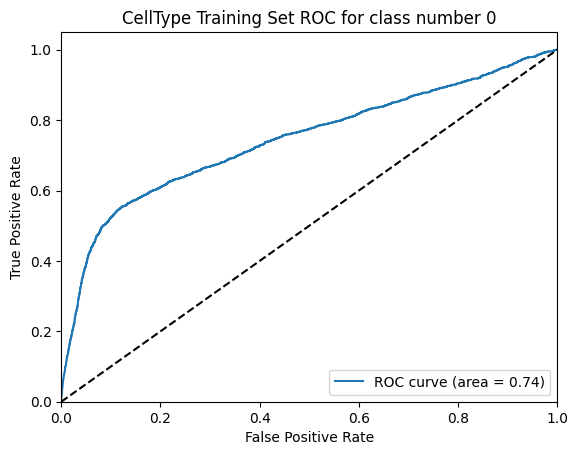

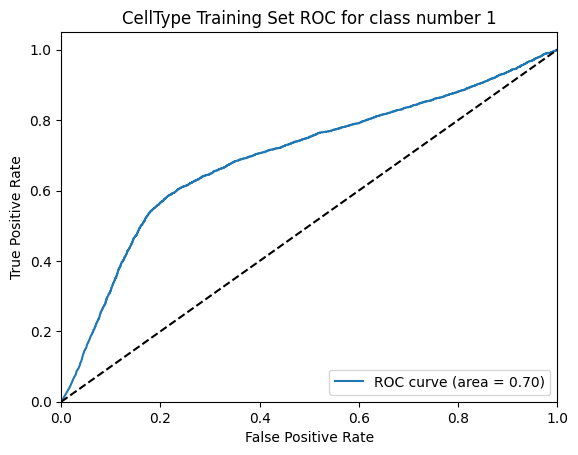

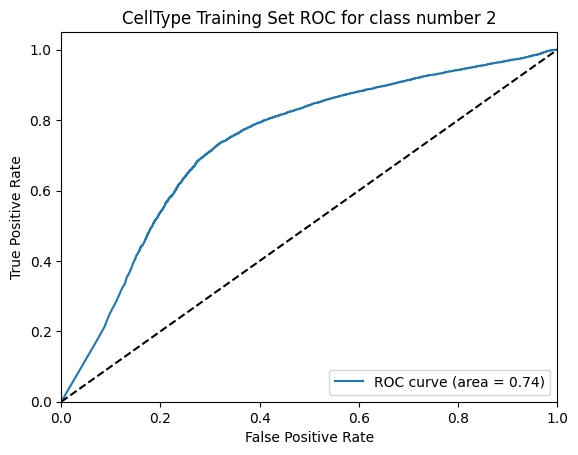

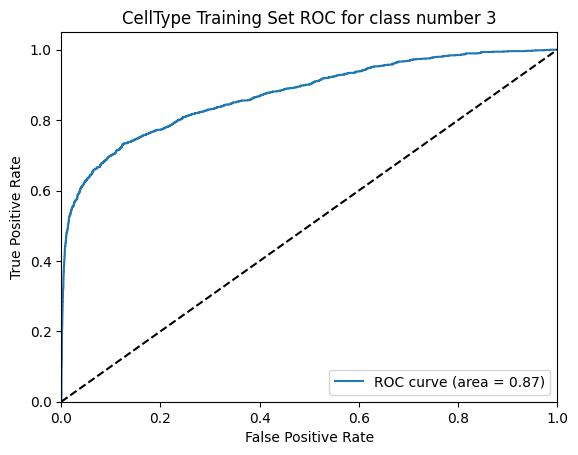

Mean ROC (Area): 0.7621856445394101


0.7621856445394101

In [20]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [21]:
testAccuracy, y_test_celltype, y_test_pred_celltype, y_test_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Test", celltype_test_dataloader, True, True)


Test:
Confusion matrix: 

[[ 99  17  18   6]
 [ 19 143  17   6]
 [ 21  29 573   0]
 [ 15  29  31   5]]

- Accuracy Score: 0.7976653696498055
- Precision Score: 0.7976653696498055
- Recall Score: 0.7976653696498055
- F1 Score: 0.7976653696498055


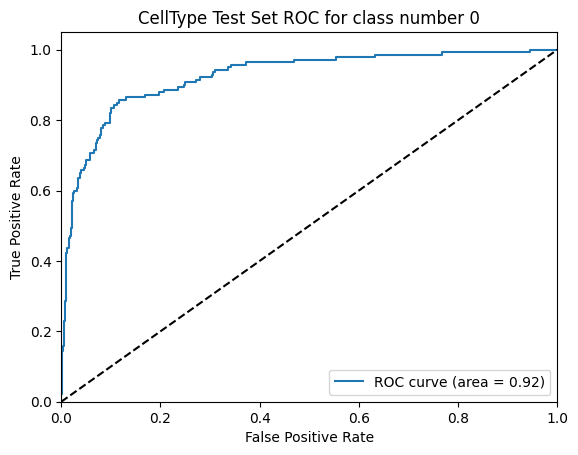

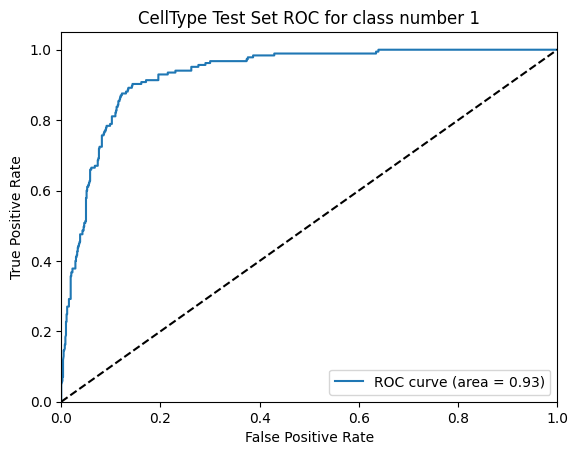

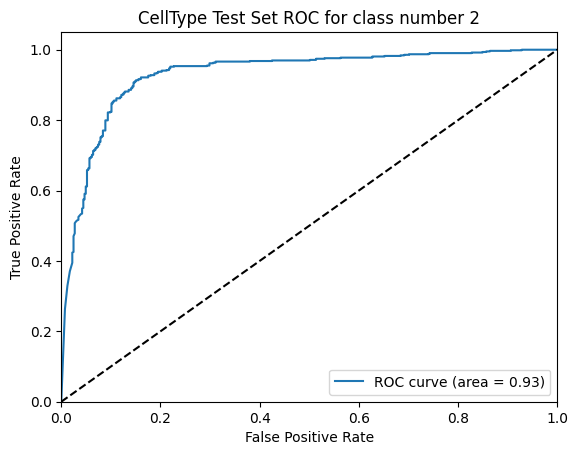

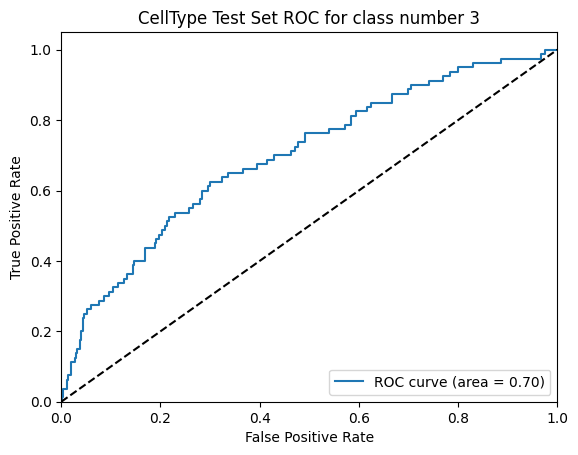

Mean ROC (Area): 0.8703710319899086


0.8703710319899086

In [22]:
a2util.getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

# Results

Append Results for both Binary IsCancerous and Cell Type here

### Cell Type Results

Best NN, 2 Layer in 05c:
- **Training**
- Accuracy Score: 0.8672961592446089
- Precision Score: 0.8672961592446089
- Recall Score: 0.8672961592446089
- F1 Score: 0.8672961592446089
- **Test**
- Accuracy Score: 0.7898832684824902
- Precision Score: 0.7898832684824902
- Recall Score: 0.7898832684824902
- F1 Score: 0.7898832684824902

Best CNN:
CNN07, updated CNN with without greyscale
- **Training**
- Accuracy Score: 0.8320786015056781
- Precision Score: 0.8320786015056781
- Recall Score: 0.8320786015056781
- F1 Score: 0.8320786015056783
- **Test**
- Accuracy Score: 0.796692607003891
- Precision Score: 0.796692607003891
- Recall Score: 0.796692607003891
- F1 Score: 0.796692607003891

This Result, Semi Supervised Learning with Best CNN, high conf threshold is 0.97, but still, most of the extra records were judged high conf in the first iteration?
- **Training**
- Accuracy Score: 0.6003440048826499
- Precision Score: 0.6003440048826499
- Recall Score: 0.6003440048826499
- F1 Score: 0.6003440048826499
- **Test**
- Accuracy Score: 0.7986381322957199
- Precision Score: 0.7986381322957199
- Recall Score: 0.7986381322957199
- F1 Score: 0.7986381322957199

Works well with unseen data but predicts very poorly on original training data. What is happening?
- Severe overfitting with the semi-supervised data?
- Possible data leakage problem?

<h1>Analysis of Performance and Accuracy</h1>

<h3>Is Cancerous</h3>
<p>
The best performing model after initial CNN experiments, according to F1 Score, is the CNN with 3 Layer Classifier, with no Early stopping. the F1 Score is <strong>0.907</strong>, which is only a 0.01 improvement on the Basic NN 2 Layer model.
</p>
<p>
There isn't much benefit in the Early Stopping process here, looking at the 3 layer experiment with and without early stopping
</p>
<p>
However, we can see that the difference between the Training F1 and the Test F1 in this CNN is a lot smaller, with the Training F1 being 0.93. This is a situation where we have higher bias but less variance, with higher bias compared to other experiments. Therefore, it may be possible to model with more accuracy to reduce the bias, however, we must be careful not to overfit.
</p>

<h3>Cell Type</h3>
<p>
The best performing model after initial CNN experiments, according to Accuracy, is the CNN with 3 Layer Classifier, with Early stopping. the F1 Score is <strong>0.796</strong>, which is a 0.018 improvement on the Basic NN 2 Layer model.
</p>
<p>
However, we can see that the difference between the Training Accuracy and the Test Accuracy in this CNN very small, with the Testing accuracy being <strong>0.81</strong>. This indicates that the model is generalizing very well. However, it appears that this model has a higher bias than other experiments.
</p>

<h3>Conclusion</h3>
<p>
Therefore, for both models, it is worth experimenting on how accuracy can be improved. There are 3 methods that initially should be tried
</p>
<ol>
<li>First, experiment with a more complex CNN model, with additional complexity in the Convolution and the Classifier parts</li>
<li>Addition of more data to train with, specifically the Extra data provided</li>
<li>Data Augmentation</li>
</ol>

